In [5]:
# Import required libraries
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add utils to path
sys.path.append('../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Custom dataset loader
from dataset_loader import FODDatasetConfig, FODDatasetLoader, validate_dataset

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")
print(f"Python: {sys.version}")
print(f"Working Directory: {os.getcwd()}")

✓ Libraries imported successfully!
Python: 3.13.1 (tags/v3.13.1:0671451, Dec  3 2024, 19:06:28) [MSC v.1942 64 bit (AMD64)]
Working Directory: d:\Zaryab\Course Work\Machine Learning\ML Project\Code\notebooks


In [6]:
# Force reload the dataset_loader module to get the updated CLASSES list
import importlib
import dataset_loader
importlib.reload(dataset_loader)
from dataset_loader import FODDatasetConfig, FODDatasetLoader, validate_dataset

print("✓ Module reloaded successfully!")
print(f"Number of classes: {len(FODDatasetConfig.CLASSES)}")
print(f"Classes: {FODDatasetConfig.CLASSES}")

✓ Module reloaded successfully!
Number of classes: 41
Classes: ['adjustableclamp', 'adjustablewrench', 'backpack', 'battery', 'bolt', 'boltnutset', 'boltwasher', 'bottle', 'clamp', 'clamppart', 'cloth', 'cutter', 'fuelcap', 'glove', 'hammer', 'hose', 'label', 'luggagetag', 'metalbracket', 'metalsheet', 'nail', 'nut', 'paintchip', 'pen', 'pliers', 'poweradapter', 'rope', 'rubberbelt', 'screw', 'screwdriver', 'seal', 'sodacan', 'spring', 'tape', 'tie', 'washer', 'wire', 'woodenpiece', 'woodscrew', 'wrappingpaper', 'wrench']


## 1. Dataset Structure Validation

First, we validate that the FOD-A dataset is properly organized in YOLO format.

**Expected Structure:**
```
data/FOD-A/
├── images/
│   ├── train/
│   ├── val/
│   └── test/  (optional)
├── labels/
│   ├── train/
│   ├── val/
│   └── test/  (optional)
└── data.yaml  (will be auto-generated)
```

In [8]:
# Define dataset path
DATASET_ROOT = "../data/FOD-A"

# Validate dataset structure
is_valid = validate_dataset(DATASET_ROOT)

if not is_valid:
    print("\n❌ Dataset validation failed!")
    print("Please ensure FOD-A dataset is placed in the correct location.")
    print("See README.md for dataset structure requirements.")
else:
    print("\n✅ Dataset is ready for training!")

🔍 Validating FOD-A Dataset...
📁 Root: ../data/FOD-A

✓ Dataset structure valid
✓ TRAIN: 25298 images
✓ VAL: 8429 images

✅ Dataset validation complete!

✅ Dataset is ready for training!


## 2. Dataset Statistics Overview

Calculate comprehensive statistics for the training and validation splits.

In [7]:
# Initialize loader
loader = FODDatasetLoader(DATASET_ROOT)

# Get statistics for train and val splits
print("📊 Calculating dataset statistics...\n")

train_stats = loader.get_dataset_statistics('train')
val_stats = loader.get_dataset_statistics('val')

# Display summary
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"\nTraining Set:")
print(f"  Images:      {train_stats['total_images']:,}")
print(f"  Annotations: {train_stats['total_annotations']:,}")
print(f"  Avg objects/image: {train_stats['total_annotations']/train_stats['total_images']:.2f}")

print(f"\nValidation Set:")
print(f"  Images:      {val_stats['total_images']:,}")
print(f"  Annotations: {val_stats['total_annotations']:,}")
print(f"  Avg objects/image: {val_stats['total_annotations']/val_stats['total_images']:.2f}")

print(f"\n{'='*60}")

📊 Calculating dataset statistics...

DATASET SUMMARY

Training Set:
  Images:      25,298
  Annotations: 25,793
  Avg objects/image: 1.02

Validation Set:
  Images:      8,429
  Annotations: 8,613
  Avg objects/image: 1.02

DATASET SUMMARY

Training Set:
  Images:      25,298
  Annotations: 25,793
  Avg objects/image: 1.02

Validation Set:
  Images:      8,429
  Annotations: 8,613
  Avg objects/image: 1.02



## 3. Object Size Distribution Analysis

**Critical for FOD Detection:** The paper states that >85% of objects in FOD-A occupy <20% of image area.

We categorize objects by size:
- **Small**: < 32×32 pixels (most challenging)
- **Medium**: 32×32 to 96×96 pixels
- **Large**: > 96×96 pixels

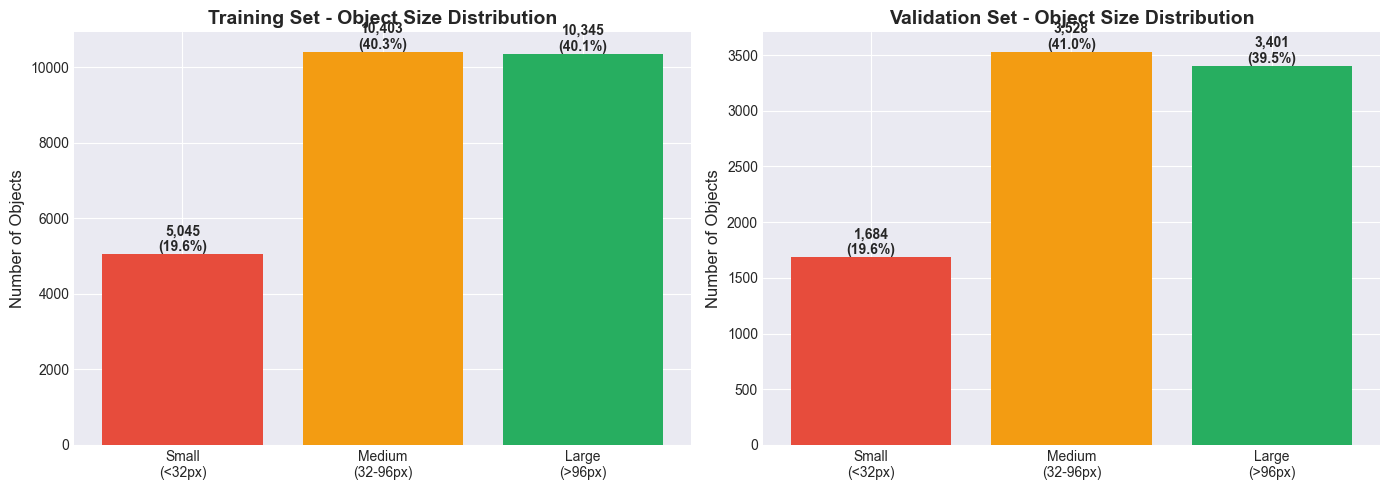


⚠️ Small objects comprise 19.6% of training data
This validates the need for P2 detection heads and SAHI!


In [9]:
# Object size distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
sizes = ['Small\n(<32px)', 'Medium\n(32-96px)', 'Large\n(>96px)']
train_counts = [train_stats['small_objects'], train_stats['medium_objects'], train_stats['large_objects']]
train_pcts = [c/sum(train_counts)*100 for c in train_counts]

axes[0].bar(sizes, train_counts, color=['#e74c3c', '#f39c12', '#27ae60'])
axes[0].set_title('Training Set - Object Size Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Objects', fontsize=12)
for i, (count, pct) in enumerate(zip(train_counts, train_pcts)):
    axes[0].text(i, count, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Validation set
val_counts = [val_stats['small_objects'], val_stats['medium_objects'], val_stats['large_objects']]
val_pcts = [c/sum(val_counts)*100 for c in val_counts]

axes[1].bar(sizes, val_counts, color=['#e74c3c', '#f39c12', '#27ae60'])
axes[1].set_title('Validation Set - Object Size Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Objects', fontsize=12)
for i, (count, pct) in enumerate(zip(val_counts, val_pcts)):
    axes[1].text(i, count, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/object_size_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n⚠️ Small objects comprise {train_pcts[0]:.1f}% of training data")
print("This validates the need for P2 detection heads and SAHI!")

## 4. Class Distribution Analysis

FOD-A contains 31 object classes. The dataset is **imbalanced** (some classes are much more common than others).

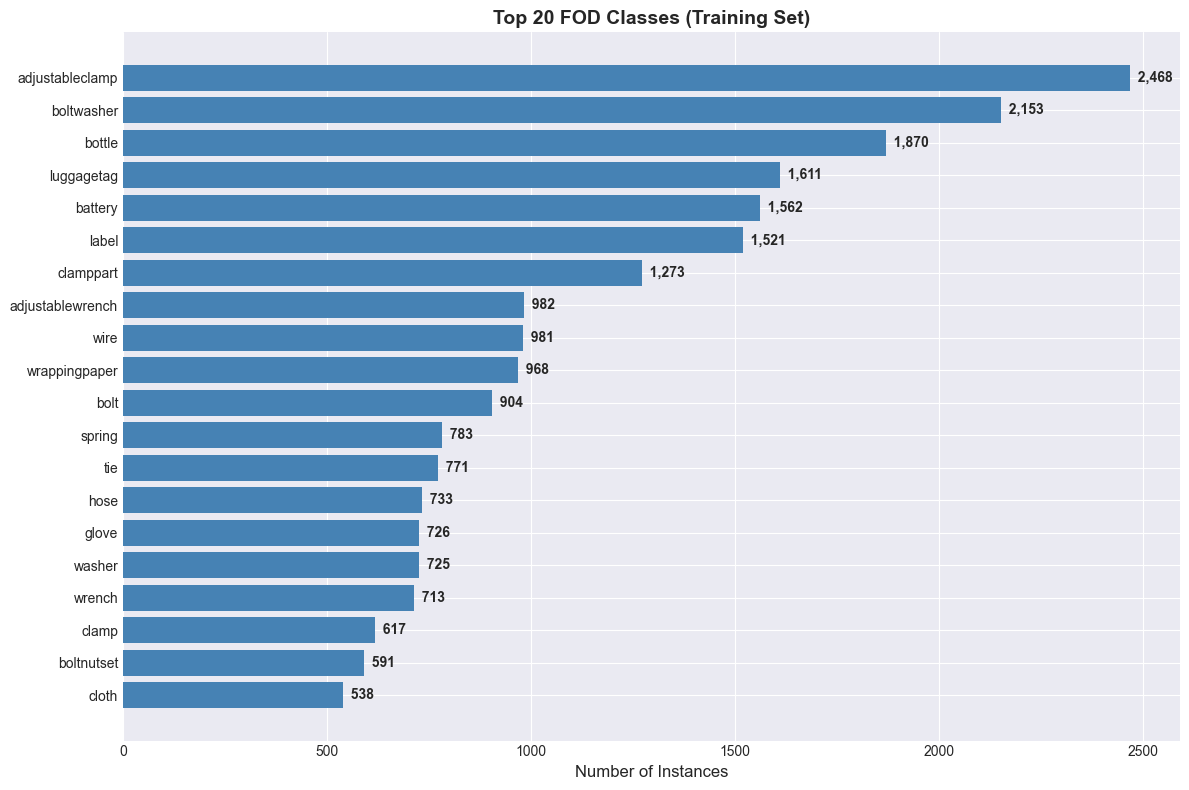


📈 Class Distribution Statistics:
  Most common: adjustableclamp (2,468 instances)
  Least common: rope (95 instances)
  Imbalance ratio: 26.0:1

⚠️ High imbalance detected - consider weighted loss functions!


In [10]:
# Prepare class distribution data
train_class_df = pd.DataFrame({
    'Class': list(train_stats['class_counts'].keys()),
    'Count': list(train_stats['class_counts'].values())
}).sort_values('Count', ascending=False)

# Remove classes with 0 count
train_class_df = train_class_df[train_class_df['Count'] > 0]

# Plot top 20 classes
fig, ax = plt.subplots(figsize=(12, 8))
top_n = min(20, len(train_class_df))
top_classes = train_class_df.head(top_n)

bars = ax.barh(top_classes['Class'], top_classes['Count'], color='steelblue')
ax.set_xlabel('Number of Instances', fontsize=12)
ax.set_title(f'Top {top_n} FOD Classes (Training Set)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add count labels
for i, (idx, row) in enumerate(top_classes.iterrows()):
    ax.text(row['Count'], i, f"  {row['Count']:,}", va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Display statistics
print("\n📈 Class Distribution Statistics:")
print(f"  Most common: {train_class_df.iloc[0]['Class']} ({train_class_df.iloc[0]['Count']:,} instances)")
print(f"  Least common: {train_class_df.iloc[-1]['Class']} ({train_class_df.iloc[-1]['Count']:,} instances)")
print(f"  Imbalance ratio: {train_class_df.iloc[0]['Count'] / train_class_df.iloc[-1]['Count']:.1f}:1")
print("\n⚠️ High imbalance detected - consider weighted loss functions!")

## 5. Bounding Box Area Distribution

Analyze the distribution of bounding box areas to understand the scale of objects we're detecting.

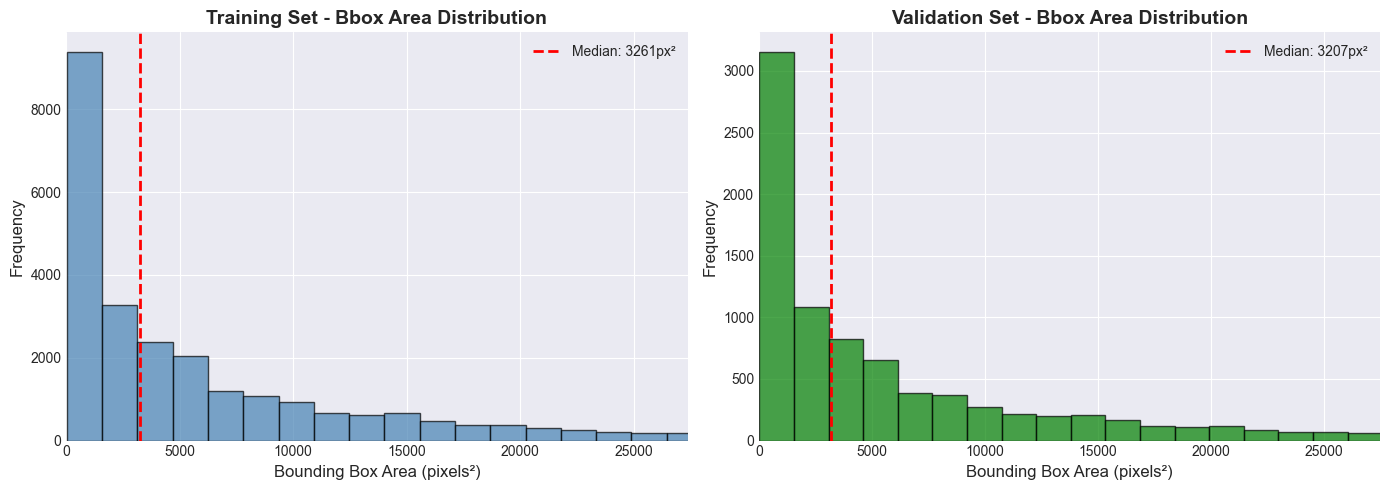


📏 Bounding Box Area Statistics (Training):
  Median:  3261 px²
  75th %:  9309 px²
  90th %:  19262 px²
  95th %:  27379 px²
  99th %:  46069 px²


In [11]:
# Bounding box area analysis
train_areas = np.array(train_stats['bbox_areas'])
val_areas = np.array(val_stats['bbox_areas'])

# Calculate percentiles
train_percentiles = np.percentile(train_areas, [25, 50, 75, 90, 95, 99])
val_percentiles = np.percentile(val_areas, [25, 50, 75, 90, 95, 99])

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_areas, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(train_percentiles[1], color='red', linestyle='--', linewidth=2, label=f'Median: {train_percentiles[1]:.0f}px²')
axes[0].set_xlabel('Bounding Box Area (pixels²)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Training Set - Bbox Area Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(train_areas, 95))  # Zoom to 95th percentile

axes[1].hist(val_areas, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].axvline(val_percentiles[1], color='red', linestyle='--', linewidth=2, label=f'Median: {val_percentiles[1]:.0f}px²')
axes[1].set_xlabel('Bounding Box Area (pixels²)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Validation Set - Bbox Area Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(0, np.percentile(val_areas, 95))

plt.tight_layout()
plt.savefig('../results/bbox_area_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Display statistics
print("\n📏 Bounding Box Area Statistics (Training):")
print(f"  Median:  {train_percentiles[1]:.0f} px²")
print(f"  75th %:  {train_percentiles[2]:.0f} px²")
print(f"  90th %:  {train_percentiles[3]:.0f} px²")
print(f"  95th %:  {train_percentiles[4]:.0f} px²")
print(f"  99th %:  {train_percentiles[5]:.0f} px²")

## 6. Sample Visualization

Visualize random samples from the dataset with bounding boxes and labels.

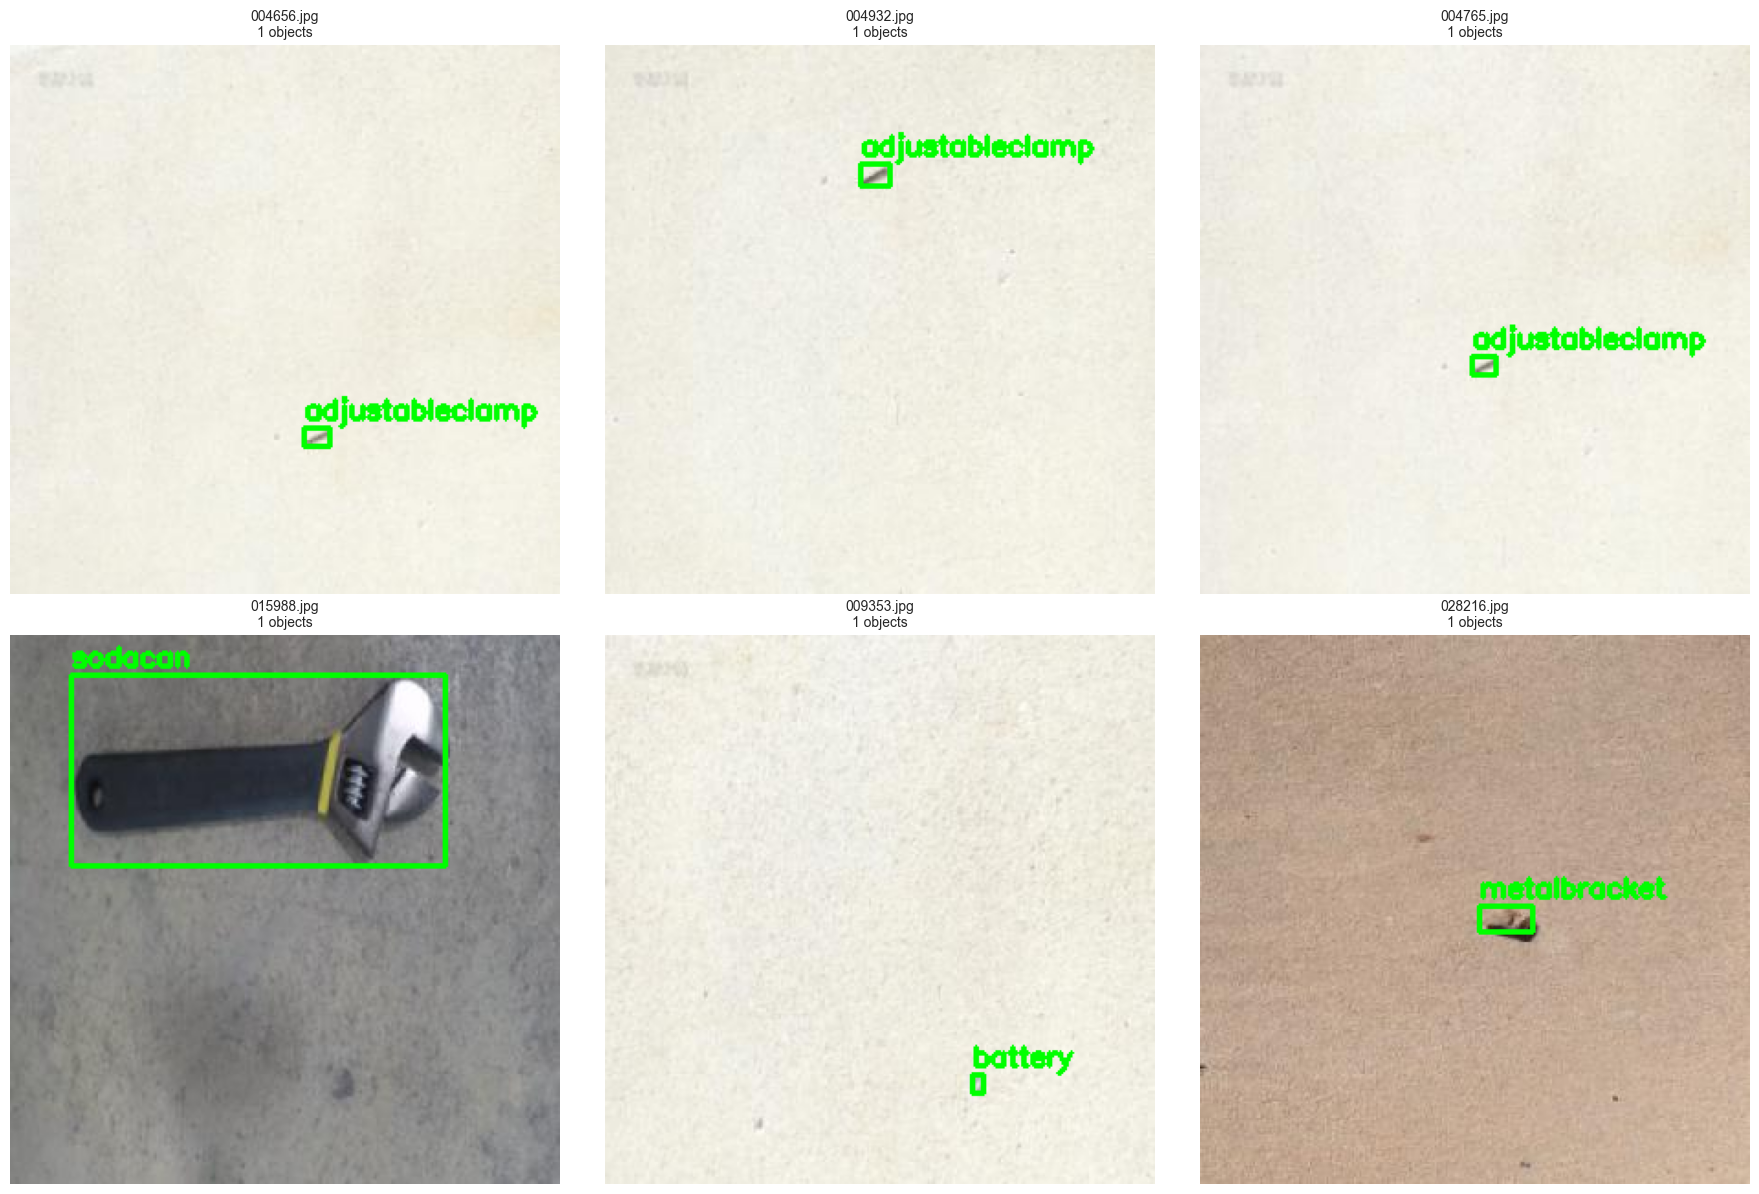

✓ Visualized 6 random samples


In [13]:
# Visualize random samples
from pathlib import Path
import random

# Get random training images
train_images_dir = Path(DATASET_ROOT) / 'images' / 'train'
all_images = list(train_images_dir.glob('*.jpg')) + list(train_images_dir.glob('*.png'))
sample_images = random.sample(all_images, min(6, len(all_images)))

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    img, annotations = loader.load_image_with_annotations(img_path, 'train')
    img_h, img_w = img.shape[:2]
    
    # Draw bounding boxes
    for ann in annotations:
        x1, y1, x2, y2 = loader.get_bbox_absolute(ann, img_w, img_h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = ann['class_name']
        cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (0, 255, 0), 2)
    
    axes[idx].imshow(img)
    axes[idx].set_title(f'{img_path.name}\n{len(annotations)} objects', fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../results/sample_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualized {len(sample_images)} random samples")

## 7. Summary and Recommendations

Based on the dataset analysis, here are key findings and recommendations for model training.

In [14]:
# Generate summary report
print("="*60)
print("DATASET ANALYSIS SUMMARY & RECOMMENDATIONS")
print("="*60)

print("\n📊 KEY FINDINGS:")
print(f"  1. Small object dominance: {train_pcts[0]:.1f}% of objects are <32px")
print(f"  2. Class imbalance ratio: {train_class_df.iloc[0]['Count'] / train_class_df.iloc[-1]['Count']:.1f}:1")
print(f"  3. Median bbox area: {train_percentiles[1]:.0f} px²")
print(f"  4. Average objects per image: {train_stats['total_annotations']/train_stats['total_images']:.2f}")

print("\n💡 RECOMMENDATIONS:")
print("  ✓ Use P2 detection head (stride=4) for small objects")
print("  ✓ Implement SAHI for inference on high-res images")
print("  ✓ Apply class weights or focal loss for imbalance")
print("  ✓ Use heavy augmentation (Mosaic, MixUp)")
print("  ✓ Train with larger image sizes (1280×1280 recommended)")
print("  ✓ Monitor AP_small metric specifically")

print("\n🎯 TARGET METRICS:")
print(f"  Baseline (Paper):  mAP = 93.8%")
print(f"  Our Target:        mAP > 94.0%, AP_small > baseline")

print(f"\n{'='*60}")
print("✅ Dataset exploration complete! Ready for training.")
print(f"{'='*60}\n")

DATASET ANALYSIS SUMMARY & RECOMMENDATIONS

📊 KEY FINDINGS:
  1. Small object dominance: 19.6% of objects are <32px
  2. Class imbalance ratio: 26.0:1
  3. Median bbox area: 3261 px²
  4. Average objects per image: 1.02

💡 RECOMMENDATIONS:
  ✓ Use P2 detection head (stride=4) for small objects
  ✓ Implement SAHI for inference on high-res images
  ✓ Apply class weights or focal loss for imbalance
  ✓ Use heavy augmentation (Mosaic, MixUp)
  ✓ Train with larger image sizes (1280×1280 recommended)
  ✓ Monitor AP_small metric specifically

🎯 TARGET METRICS:
  Baseline (Paper):  mAP = 93.8%
  Our Target:        mAP > 94.0%, AP_small > baseline

✅ Dataset exploration complete! Ready for training.



## Next Steps

1. **Week 1**: Train YOLOv8-P2 baseline model
2. **Week 2**: Experiment with YOLOv11 and SAHI
3. **Week 3**: Adversarial testing and final evaluation

**To start training**, see the training notebooks in this directory.